In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [17]:
training_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
all_data = [training_data, test_data]
data = pd.concat(all_data)

training_data.info()
print('_'*40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

In [18]:
training_data.describe()
# Notes: 891 entries, 40 of total passengers on Titanic (2,224)
# around a 38% survival rate
# most did not travel with family
# very few elderly passengers

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [19]:
# Categorical features
training_data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Ilett, Miss. Bertha",male,CA. 2343,G6,S
freq,1,577,7,4,644


### Observations
* Training set contains 891 entries, approximately 40% of total passengers on Titanic (2,224). 
* Survival rate for the training data is approximately 38%. 
* Most people did not travel with parents or children, but at least 25% traveled with siblings or a spouse. 
* Most passengers were of pclass 3 (lower class).
* Age is missing some values; consider filling in these values since age is most likely an important feature
* Cabin is missing a lot of entries and has some duplicates; most likely be dropped
* Embarked is missing 2 entries; consider filling in
* More males than females (577/891)
* All names are unique
* Some repeated tickets; consider dropping


## Asumptions
#### Correlation
* Find out which features correlate to Survival. We might also want to investigate which features correlate with each other

#### Completing
* We should consider completing the age and embarked data

#### Creating
* We should consider creating some new features such as:
    * Family
    * Title - based on name
    * Use age brackets to transform age from continuous to ordinal
    * Classify fares into range?

#### Classifying
* Check out the following assumptions based on the description:
    * Women had a higher survival rate than men
    * Children had a higher survival rate
        * Todo: figure out age bracket
    * Upper class passengers (Pclass=1) were more likely to survive

In [20]:
# Checking out the correlation between class and survival
training_data[['Survived','Pclass']].groupby(['Pclass']).mean().sort_values(by='Survived', ascending=False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [21]:
# Checking out the correlation between gender and survival
training_data[['Survived','Sex']].groupby(['Sex']).mean().sort_values(by='Survived', ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


In [22]:
# Checking out correlation between SibSp and Survival
training_data[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [23]:
# Checking out correlation between Parch and Survival
training_data[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)
# no clear correlations

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


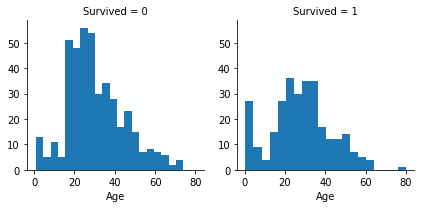

In [24]:
# Checking out relationship between Age and Survival
# Most people died between app. 16-32
# Infants/young children survived up to a certain point
# Looks it makes sense to split up ages into groups of 4
s = sns.FacetGrid(training_data, col='Survived')
s.map(plt.hist, 'Age', bins = 20)

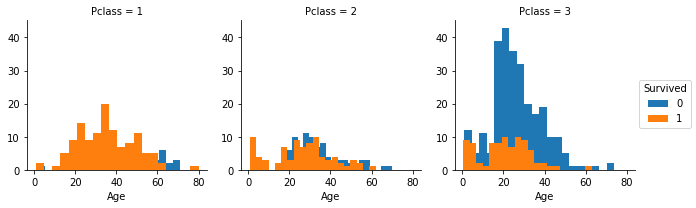

In [25]:
# Checking out relationship between Age, Pclass, and Survival
grid = sns.FacetGrid(training_data, col='Pclass', hue='Survived')
#grid = sns.FacetGrid(training_data, col='Survived', row='Pclass')
grid.map(plt.hist, 'Age', bins=20)
grid.add_legend()

# More people in pclass=3 died than in any other pclass
# Pclass=1 had most survivors
# pclass=3 had majority of the passengers ages 16-32
# looks like there's some relationship between class and age

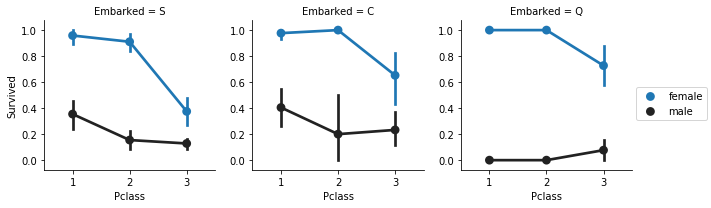

In [26]:
# Checking out relationship between Embarked, Pclass, Sex, and Survival
grid = sns.FacetGrid(training_data, col='Embarked')
grid.map(sns.pointplot, 'Pclass','Survived', 'Sex', order=[1,2,3], hue_order=['male', 'female'], aspect=1.5, size=2)
grid.add_legend()
# Females had a much better survival rate
# 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


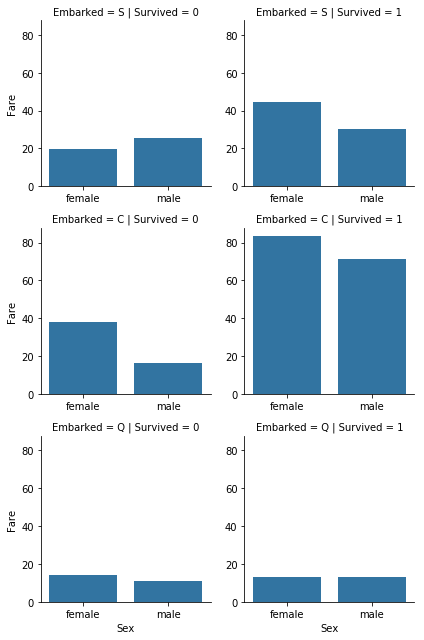

In [27]:
# Checking out relationship between Embarked, Fare, Sex, and Survival
grid = sns.FacetGrid(training_data, row="Embarked", col='Survived')
grid.map(sns.barplot, 'Sex', 'Fare', ci=None)
# Q had much lower fares
# People who paid more had a higher chance of survival

## Wrangle Data

In [28]:
# Drop Ticket and Cabin columns
print("Before:", training_data.shape, test_data.shape, all_data[0].shape, all_data[1].shape)

training_data = training_data.drop(columns=['Ticket', 'Cabin'])
test_data = test_data.drop(columns=['Ticket', 'Cabin'])
all_data = [training_data, test_data]

print("After:", training_data.shape, test_data.shape, all_data[0].shape, all_data[1].shape)

Before: (891, 12) (418, 11) (891, 12) (418, 11)
After: (891, 10) (418, 9) (891, 10) (418, 9)


In [29]:
# Extract title from Name column

for ds in all_data:
    ds['Title'] = ds.Name.str.extract(" ([A-Za-z]+)\. ", expand=False)

pd.crosstab(training_data['Title'], training_data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [30]:
training_data.describe(include=['O'])

,Name,Sex,Embarked,Title
count,891,891,889,891
unique,891,2,3,17
top,"Ilett, Miss. Bertha",male,S,Mr
freq,1,577,644,517


Every passenger has a title, and most passengers have a title of Mr., Miss., Mrs., or Master


In [31]:
for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
training_data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


The means seem to agree with the assumption that men had a lower survival rate than woman. Master, however, is nearly split. We should investigate this later. We might also experiment with the title replacements.

For now, let's convert Title to an ordinal value

In [32]:
title_mapping = { 'Mr' : 1, 'Miss' : 2, 'Mrs' : 3, 'Master' : 4, 'Rare' : 5 }

for ds in all_data:
    ds['Title'] = ds['Title'].map(title_mapping)
    ds['Title'] = ds['Title'].fillna(0)

In [33]:
# Check that it worked
training_data.head()
#training_data.describe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


Now we can safely drop the Name feature:

In [34]:
print(training_data.shape, test_data.shape)

training_data = training_data.drop(columns=['Name'])
test_data = test_data.drop(columns=['Name'])
all_data = [training_data, test_data]

print(training_data.shape, test_data.shape)

(891, 11) (418, 10)
(891, 10) (418, 9)


## Convert categorical features to numeric representations

In [35]:
for ds in all_data:
    ds['Sex'] = ds['Sex'].map({'male' : 1, 'female' : 0})

training_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,1,22.0,1,0,7.2500,S,1
1,2,1,1,0,38.0,1,0,71.2833,C,3
2,3,1,3,0,26.0,0,0,7.9250,S,2
3,4,1,1,0,35.0,1,0,53.1000,S,3
4,5,0,3,1,35.0,0,0,8.0500,S,1


## Completing Features

#### Filling in Age
Previously, we saw a correlation between Age, Pclass, and Sex. We will use this correlation to generate guesses for the ages using two methods:

1. A random number between one standard deviation on either side of the mean
2. The median



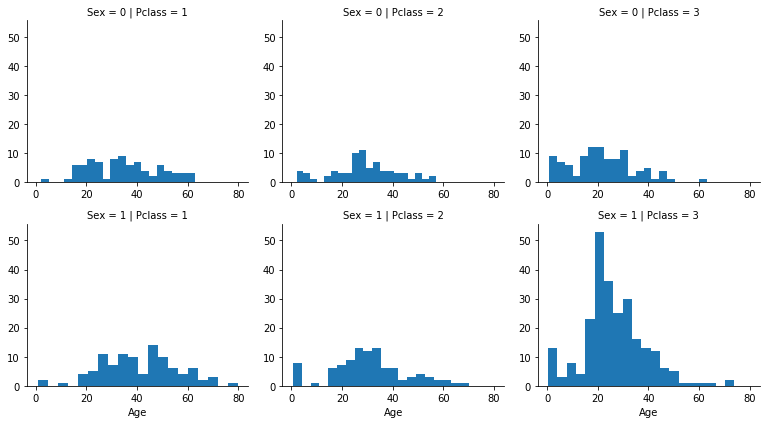

In [36]:
grid = sns.FacetGrid(training_data, col='Pclass', row='Sex', size=3, aspect=1.2)
grid.map(plt.hist, 'Age', bins=20)

In [42]:
# iterate over pclass and sex and guess age values
guess_ages = np.zeros((2,3))

for dataset in all_data:
    # sex {0 or 1}
    for i in range(2):
        # pclass 1,2,3
        for j in range(3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()
            ## Using a random num < 1 std away from the mean
            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)
            
            ## Using the median
            age_guess = guess_df.median()
            
            ## Round to the nearest .5
            guess_ages[i, j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(2):
        for j in range(3):
            dataset.loc[ (dataset.Age.isnull() ) & ( dataset.Sex == i) & ( dataset.Pclass == j+1), \
                        'Age'] = guess_ages[i, j]
    dataset['Age'] = dataset['Age'].astype(int)
            
            
training_data.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,1,22,1,0,7.2500,S,1
1,2,1,1,0,38,1,0,71.2833,C,3
2,3,1,3,0,26,0,0,7.9250,S,2
3,4,1,1,0,35,1,0,53.1000,S,3
4,5,0,3,1,35,0,0,8.0500,S,1


Create age bands: 
            

In [45]:
training_data['AgeBand'] = pd.cut(training_data['Age'], 5)
training_data[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)


,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [ ]:
Create ordinals for Age based on the above bands

In [47]:
for dataset in all_data:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[ (dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[ (dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[ (dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ (dataset['Age'] > 64), 'Age'] = 4

training_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,1,0,3,1,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,2,1,1,0,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,3,1,3,0,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,4,1,1,0,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,5,0,3,1,2,0,0,8.0500,S,1,"(32.0, 48.0]"


In [48]:
training_data = training_data.drop(columns=['AgeBand'])
all_data = [training_data, test_data]
training_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,1,1,1,0,7.2500,S,1
1,2,1,1,0,2,1,0,71.2833,C,3
2,3,1,3,0,1,0,0,7.9250,S,2
3,4,1,1,0,2,1,0,53.1000,S,3
4,5,0,3,1,2,0,0,8.0500,S,1


In [51]:
for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

training_data[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(\
                                                                            by='Survived', ascending=False)



,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [53]:
for dataset in all_data:
    dataset['IsAlone'] = 0
    dataset.loc[ dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
training_data[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [54]:
training_data = training_data.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_data = test_data.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
all_data = [training_data, test_data]

training_data.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,1,0,3,1,1,7.2500,S,1,0
1,2,1,1,0,2,71.2833,C,3,0
2,3,1,3,0,1,7.9250,S,2,1
3,4,1,1,0,2,53.1000,S,3,0
4,5,0,3,1,2,8.0500,S,1,1


In [55]:
# Artificial feature combing Age and Pclass
for dataset in all_data:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass
    
training_data.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


In [59]:
# Complete Embarked with most embarked from port
m = training_data.Embarked.dropna().mode()[0]

for dataset in all_data:
    dataset['Embarked'] = dataset['Embarked'].fillna(m)
    
for dataset in all_data:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

    
training_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(\
    by='Survived', ascending=False)

,Embarked,Survived
1,1,0.553571
2,2,0.389610
0,0,0.339009


In [60]:
# Complete Fare using mode (only one value missing)
test_data.fillna( test_data['Fare'].dropna().mode(), inplace=True)
test_data.head()
    

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,1,2,7.8292,2,1,1,6
1,893,3,0,2,7.0000,0,3,0,6
2,894,2,1,3,9.6875,2,1,1,6
3,895,3,1,1,8.6625,0,1,1,3
4,896,3,0,1,12.2875,0,3,0,3


In [61]:
training_data['FareBand'] = pd.qcut(training_data['Fare'], 4)
training_data[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081
